### Import Necessary Libraries

In this cell, we import the necessary libraries for our image captioning model. These libraries include PyTorch for building and training the model, and torchvision for pre-trained models and transformations.

1. **`torch`**: This is the main PyTorch library which provides the core functionalities for tensor operations, neural network layers, and optimization.
2. **`torch.nn`**: This module contains classes and functions to build neural networks. It includes pre-defined layers like `Linear` and `Dropout`, as well as loss functions like `CrossEntropyLoss`.
3. **`torchvision.models`**: This module provides access to pre-trained models and model architectures. Here, we use it to import `ResNet18`, a commonly used model for image classification tasks.
4. **`os`**: Provides functions to interact with the operating system, like file path manipulation.
5. **`pandas`**: A library for data manipulation and analysis, especially useful for handling tabular data.
6. **`keras_preprocessing.text`**: A library for handling various transformations over text.
7. **`Counter`**: A class from collections used for evaluation of frequencies of words in a text.
8. **`DataLoader` and `Dataset`**: PyTorch utilities for loading and managing data efficiently.
9. **`Image`**: A class from PIL (Python Imaging Library) used to open and manipulate images.
10. **`matplotlib`**: A library for plotting and visualization of models and images.


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import torch
import torchvision
import torch.nn as nn
import torchvision.models.resnet as resnet
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from tensorflow.keras.utils import Progbar

### Define Constants

This cell defines several constants used throughout the notebook. Constants help maintain consistency and simplify code updates.

1. **`START_TOKEN`, `END_TOKEN`, `PAD_TOKEN`, `UNKNOWN_TOKEN`**: These are special tokens used in text processing. They represent the start of a sequence, end of a sequence, padding, and unknown words, respectively.
2. **`EMBEDDING_SIZE`**: This defines the size of the word embeddings used in the model. Larger sizes can capture more information but require more computational resources.
3. **`HIDDEN_SIZE`**: This is the number of features in the hidden state of the LSTM (Long Short-Term Memory) network. It determines the capacity of the LSTM to capture dependencies in sequences.
4. **`NUM_LAYERS`**: This represents the number of LSTM layers stacked on top of each other. More layers can help the model learn more complex patterns.
5. **`BATCH_SIZE`**: This defines how many samples are processed together in one forward/backward pass. Larger batches can speed up training but require more memory.
6. **`NUM_EPOCHS`**: This is the number of times the entire training dataset is passed through the model during training.
7. **`LEARNING_RATE`**: This is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.


In [7]:
START_TOKEN = "<START>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"
UNKOWN_TOKEN = "<UNKOWN>"
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 256
NUM_LAYERS = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FOLDER_PATH = r"F:\Programming\Python\Deep Learning\Image-Captioning\data\raw"
IMAGES_FOLDER = r"F:\Programming\Python\Deep Learning\Image-Captioning\data\raw\Images"
CAPTIONS_FOLDER = r"F:\Programming\Python\Deep Learning\Image-Captioning\data\raw\captions.txt"
CHECKPOINT_DIR = r"F:\Programming\Python\Deep Learning\Image-Captioning\src\training\checkpoints"
RUNS_DIR = r"F:\Programming\Python\Deep Learning\Image-Captioning\src\training\runs"
DATA_DIR = r"F:\Programming\Python\Deep Learning\Image-Captioning\data"

### Image Captioning Dataset

This class constructs a `Dataset` using the given images and captions that can be used by Dataloader to train the Model.

1. **`INIT`**: The initial function to construct some initial parameters.
    - `self.mapping`: A dictionary mapping each image to its corresponding list of captions.
    - `self.all_captions`: A list to store all the preprocessed captions.
    - `self.vocab`: A dictionary in which we keep every word in our vocabulary and give a unique index to each of them.
    - `self.tokenizer`: A Module used to tokenize our captions.
2. **`load_captions`**: Loads the captions from the provided file and creates the `mapping` dictionary.
3. **`build_vocab`**: Function to build the vocabulary from the captions based on their frequencies.
4. **`preprocess_captions`**: Preprocesses the captions by adding start and end tokens, and cleans the captions by removing punctuation and converting them to lowercase.
5. **`calculate_max_length`**: Calculates the maximum length of all captions to be used for padding.
6. **`pad_captions`**: Pads all captions to the maximum length using the maximum length.
7. **`__len__`**: Returns the total length of the dataset.
8. **`__getitem__`**: Returns a tuple containing the image and its corresponding caption after preprocessing.

In [9]:
class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, captions_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.mapping = self.load_captions(captions_file)
        self.all_captions = []
        self.preprocess_captions()
        self.vocab = self.build_vocab(self.mapping)
        self.add_tokens()
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(self.all_captions)
        self.vocab_size = len(self.vocab)
        self.max_length = self.calculate_max_length()
        self.pad_captions()


    def load_captions(self, captions_file):
        captions = {}
        with open(captions_file, 'r') as f:
            next(f)
            for line in f:
                tokens = line.split(',')
                img_id = tokens[0]
                caption = ''.join(tokens[1:]).strip()
                if img_id not in captions:
                    captions[img_id] = []
                captions[img_id].append(caption)
        return captions


    def build_vocab(self, captions):
        tokens = [cap.split() for caps in captions.values() for cap in caps]
        freq = Counter([item for sublist in tokens for item in sublist])
        vocab = {word: idx for idx, (word, count) in enumerate(freq.items()) if count >= 1}
        vocab[START_TOKEN] = len(vocab)
        vocab[END_TOKEN] = len(vocab)
        vocab[PAD_TOKEN] = len(vocab)
        with open(os.path.join(DATA_DIR, 'vocab.json'), "w") as vocab_file: 
            json.dump(vocab, vocab_file)
        return vocab
    

    def add_tokens(self):
        for key, captions in self.mapping.items():
            for i in range(len(captions)):
                captions[i] = START_TOKEN + " " + captions[i] + " " + END_TOKEN
                self.all_captions.append(captions[i])


    def preprocess_captions(self):
        for key, captions in self.mapping.items():
            for i in range(len(captions)):
                captions[i] = captions[i].lower().replace('.', '').replace(',', '').replace('!', '').replace('?', '').replace('\"', '')


    def calculate_max_length(self):
        return max(len(caption.split()) for caption in self.all_captions)


    def pad_captions(self):
        for key, captions in self.mapping.items():
            for i in range(len(captions)):
                caption_len = len(captions[i].split())
                for _ in range(self.max_length - caption_len):
                    captions[i] += " " + PAD_TOKEN


    def __len__(self):
        return len(self.mapping)


    def __getitem__(self, idx):
        image_idx = idx//5
        img_id = list(self.mapping.keys())[image_idx]
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        caption_idx = idx%5
        caption = self.mapping[img_id][caption_idx]

        tokens = caption.split()
        tokenized_caption = [self.vocab.get(token) for token in tokens]

        return image, torch.tensor(tokenized_caption)

### Encoder Class

This cell defines the `Encoder` class, which is part of the image captioning model. The encoder takes images as input and generates feature representations.

1. **`__init__` Method**: This constructor initializes the encoder. It uses a pre-trained ResNet18 model from `torchvision.models` and modifies its final fully connected layer to match the desired embedding size.
   - **`self.ResNet18`**: Uses a pre-trained ResNet18 model from `torchvision.models`.
   - **`self.ResNet18.fc`**: Replaces the final fully connected layer of ResNet18 to output features of size `embedding_size`.
   - **`self.ReLU`**: Applies the ReLU activation function to the output features to introduce non-linearity.
   - **`self.Dropout`**: Applies dropout to prevent overfitting by randomly setting a fraction of the features to zero during training.

2. **`forward` Method**: This method defines the forward pass of the encoder. It takes images as input and returns the processed features.
   - **`features = self.ResNet18(images)`**: Passes the images through ResNet18 to get the feature representations.
   - **`return self.Dropout(self.ReLU(features))`**: Applies ReLU activation and dropout to the output features before returning them.

In [3]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.ResNet18 = resnet.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT, progress=True)
        self.ResNet18.fc = nn.Linear(self.ResNet18.fc.in_features, embedding_size)
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.ResNet18(images)
        return self.Dropout(self.ReLU(features))



### Decoder Class

This cell defines the `Decoder` class, which is responsible for generating captions from the features produced by the encoder. It uses an LSTM network to process sequential data.

1. **`__init__` Method**: This constructor initializes the decoder.
   - **`self.embed`**: An embedding layer that converts word indices into dense vectors of size `embedding_size`.
   - **`self.LSTM`**: An LSTM layer that processes the embedded captions along with image features. It has `hidden_size` units and `num_layers` layers.
   - **`self.Linear`**: A linear layer that maps the LSTM output to vocabulary size to predict the next word.
   - **`self.Dropout`**: Applies dropout to the embeddings to prevent overfitting.

2. **`forward` Method**: This method defines the forward pass of the decoder.
   - **`embeddings = self.Dropout(self.embed(captions))`**: Converts captions into embeddings and applies dropout.
   - **`features = features.unsqueeze(1)`**: Adds a batch dimension to the image features. The batch size is assumed to be 1 for simplicity.
   - **`embeddings = torch.cat((features, embeddings), dim=1)`**: Concatenates image features with the caption embeddings. The image features are added as the first step of the sequence.
   - **`hiddens, _ = self.LSTM(embeddings)`**: Passes the sequence through the LSTM.
   - **`outputs = self.Linear(hiddens)`**: Projects the LSTM output to vocabulary size.
   - **`return outputs`**: Returns the predicted outputs.

In [4]:
class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.LSTM = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bias=True)
        self.Linear = nn.Linear(in_features=hidden_size, out_features=vocab_size)
        self.Dropout = nn.Dropout(0.5)
        self.embed = nn.Embedding(vocab_size, embedding_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = self.Dropout(embeddings)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings), dim=1)
        embeddings = embeddings.reshape(embeddings.shape[1], embeddings.shape[0], embeddings.shape[-1])
        hiddens, _ = self.LSTM(embeddings)
        return self.Linear(hiddens)


### ImageCaptioningModel Class

This cell defines the `ImageCaptioningModel` class, which combines the encoder and decoder into a single model for generating image captions.

1. **`__init__` Method**: This constructor initializes the image captioning model.
   - **`self.Encoder`**: An instance of the `Encoder` class which extracts features from images.
   - **`self.Decoder`**: An instance of the `Decoder` class which generates captions from image features and previous captions.

2. **`forward` Method**: This method defines the forward pass of the combined model.
   - **`features = self.Encoder(images)`**: Extracts features from the input images using the encoder.
   - **`outputs = self.Decoder(features, captions)`**: Generates captions based on the extracted features and input captions using the decoder.
   - **`return outputs`**: Returns the predicted outputs.

3. **`caption` Method**: This method generates a caption for a given image.(Although this method is not used in the provided code.)
   - **`features = self.Encoder(image).unsqueeze(0)`**: Extracts features from the input image and adds a batch dimension.
   - **`states`**: Keeps track of the hidden states of the LSTM during caption generation.
   - **`for _ in range(max_length)`**: Iteratively generates words for the caption up to `max_length` words.
   - **`hiddens, states = self.Decoder.LSTM(features, states)`**: Passes the image features and previous states through the LSTM.
   - **`output = self.Decoder.Linear(hiddens.squeeze(0))`**: Projects the LSTM output to vocabulary size.
   - **`predicted = output.argmax(1)`**: Gets the index of the highest probability word.
   - **`final_caption.append(predicted.item())`**: Adds the predicted word index to the caption list.
   - **`features = self.Decoder.embed(predicted).unsqueeze(0)`**: Updates the image features with the newly predicted word embedding.
   - **`if vocab.itos[predicted.item()] == END_TOKEN`**: Checks if the end token was predicted, indicating the end of the caption.
   - **`return [vocab.itos[idx] for idx in final_caption]`**: Converts the list of word indices back to words and returns the final caption.

In [20]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptioningModel, self).__init__()
        self.Encoder = Encoder(embedding_size)
        self.Decoder = Decoder(embedding_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.Encoder(images)
        outputs = self.Decoder(features, captions)
        return outputs

    def caption(self, image, vocab : dict, max_length=40):
        inverse_dict = dict([(val, key) for key, val in vocab.items()])
        final_caption = []
        with torch.no_grad():
            features = self.Encoder(image).unsqueeze(0)
            states = None
            for _ in range(max_length):
                hiddens, states = self.Decoder.LSTM(features, states)
                output = self.Decoder.Linear(hiddens.squeeze(0))
                predicted = output.argmax(1)

                final_caption.append(predicted.item())
                features = self.Decoder.embed(predicted).unsqueeze(0)
                if inverse_dict[predicted.item()] == END_TOKEN:
                    break

        return [inverse_dict[idx] for idx in final_caption]


### Model Training

This is where we define the training loop for the image captioning model but first, we need to prepare the dataset, transform and dataloader.\n
Then, we define the model, according to the given hyperparameters.

1. **Dataset Preparation**: Load the dataset, preprocess the images and captions, and create a vocabulary.
2. **DataLoader Creation**: Create a dataloader to load the dataset in batches.
3. **Model Creation**: Create an instance of the `ImageCaptioningModel` class, specifying the hyperparameters.
4. **Training Loop**: Iterate over the dataset, pass the images through the model, calculate the loss, backpropagate the gradients, and update the model parameters.



In [24]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = ImageCaptionDataset(img_dir=IMAGES_FOLDER, captions_file=CAPTIONS_FOLDER, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ImageCaptioningModel(embedding_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=dataset.vocab_size, num_layers=NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(torch.cuda.is_available())

history = {'Loss' : []}

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    model.train()
    data_size = len(dataloader)
    pb_i = Progbar(data_size, stateful_metrics=['Loss'])
    
    for images, captions in (dataloader):
        outputs = model(images, captions[:,:-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        values=[('Loss', loss.item())]
        pb_i.add(1, values=values)
    
        history['Loss'].append(loss.item())




False
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - Loss: 1.3741
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - Loss: 1.3203
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - Loss: 1.2091
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - Loss: 1.0997
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 714s 3s/step - Loss: 1.1429
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - Loss: 0.9966
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - Loss: 0.9596
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - Loss: 0.8581
Epoch 9/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - Loss: 0.8914
Epoch 10/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - Loss: 0.9809


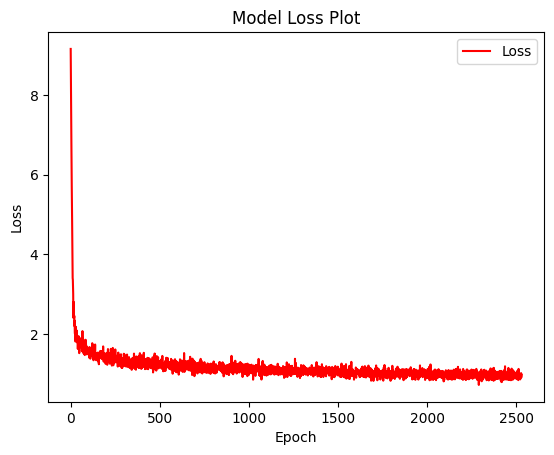

In [25]:
plt.plot(history['Loss'], 'r', label = 'Loss')
plt.title('Model Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Saving the Model

This cell saves the trained model to a file named 'image_captioning_model.pth'. This model can then be used to generate captions for new images.

In [14]:
torch.save(model.state_dict(), os.path.join(RUNS_DIR, 'image_captioning_model_1.pth'))

### Evaluate the model

This cell evaluates the model's performance on a separate test dataset.

- **`generate_caption`**: This function will take a test dataset and predict the caption for a given image.

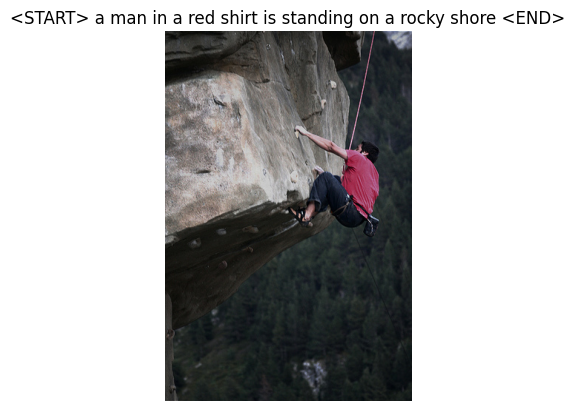

In [32]:
def generate_caption(image_path, model, dataset):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    caption = model.caption(image, dataset.vocab)
    return ' '.join(caption)

example_image_path = r'F:\Programming\Python\Deep Learning\Image-Captioning\data\raw\Images\997722733_0cb5439472.jpg'
caption = generate_caption(example_image_path, model, dataset)
# print(caption)

import cv2 as cv

img = plt.imread(example_image_path)
plt.imshow(img)
plt.title(caption)
plt.axis('off')
plt.show()
